In [16]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt


def calculate_area(masks):
    """
    Calculate the area of each mask.
    
    Parameters:
    - masks: Binary masks of connected components.
    
    Returns:
    - areas: List of areas of each mask.
    """
    return [np.sum(mask) / 255 for mask in masks]

def find_connected_components(binary_image, min_area=20):
    """
    Find connected components in a binary image.
    
    Parameters:
    - binary_image: A binary image where connected components are to be found.

    Returns:
    - masks: A list of binary masks, each representing one connected component.
    """
    num_labels, labels_im = cv2.connectedComponents(binary_image)
    masks = []

    for label in range(1, num_labels):
        mask = np.zeros_like(binary_image, dtype=np.uint8)
        mask[labels_im == label] = 255
        if np.sum(mask / 255) >= min_area: 
            masks.append(mask)
            
    return masks

def calculate_shape_features(masks):
    """
    Calculate shape features for clustering.
    Here using Hu Moments as an example.
    """
    shape_features = []
    for mask in masks:
        # Compute Hu Moments
         # Find contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Usually, the largest contour is the object of interest
        contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(contour)
        # shape_features.append(area)
        # Perimeter
        perimeter = cv2.arcLength(contour, closed=True)

        # # Solidity
        # hull = cv2.convexHull(contour)
        # hull_area = cv2.contourArea(hull)

        
        moments = cv2.moments(mask)
        hu_moments = cv2.HuMoments(moments).flatten()
        # print(area, perimeter, hu_moments)
        shape_features.append([area, perimeter, *hu_moments])
        # shape_features.append(hu_moments)
    
    scaler = MinMaxScaler()
    shape_features = np.array(shape_features)
    print(shape_features.shape)
    scaled_features = scaler.fit_transform(shape_features)
    return scaled_features

def find_pairs(masks, min_area=500):
    """
    Find pairs of masks that are similar based on shape features and have sufficient area.
    
    Parameters:
    - masks: Binary masks of connected components.
    - min_area: Minimum area to consider a mask.
    
    Returns:
    - pairs: List of index pairs indicating the masks that belong together.
    """
    shape_features = calculate_shape_features(masks)
    print(shape_features)
    areas = calculate_area(masks)
    
    # Filter and sort indices based on area
    mask_indices = [i for i, area in enumerate(areas) if area >= min_area]
    mask_indices.sort(key=lambda x: areas[x], reverse=True)
    
    # Calculate distance matrix
    num_masks = len(masks)
    dist_matrix = np.zeros((num_masks, num_masks))
    for i in range(num_masks):
        for j in range(i+1, num_masks):
            dist_matrix[i, j] = distance.euclidean(shape_features[i], shape_features[j])
            dist_matrix[j, i] = dist_matrix[i, j]
    
    pairs = []
    
    # Iteratively find the closest pair
    while mask_indices:
        i = mask_indices[0]
        if len(mask_indices) == 1:
            # pairs.append([i])
            break
        
        # Find the closest item
        min_dist = np.inf
        min_index = -1
        for j in mask_indices[1:]:
            if dist_matrix[i, j] < min_dist:
                min_dist = dist_matrix[i, j]
                min_index = j
        
        print(i, min_index, min_dist)
        if min_dist > 2:
            break
        # Add pair and remove indices
        pairs.append((i, min_index))
        mask_indices.remove(i)
        mask_indices.remove(min_index)
    
    return pairs

In [2]:
# img_pth = '/share/ymz/valisProject/results_modified/P18_2023-10-03-020128/P18/processed/P18-01.png'
import cv2
img_pth = '/share/ymz/valisProject/results_modified/P19_2023-10-03-021137/P19/processed/P19-02.png'
img = cv2.imread(img_pth, cv2.IMREAD_GRAYSCALE)

In [3]:
img.shape

(371, 432)

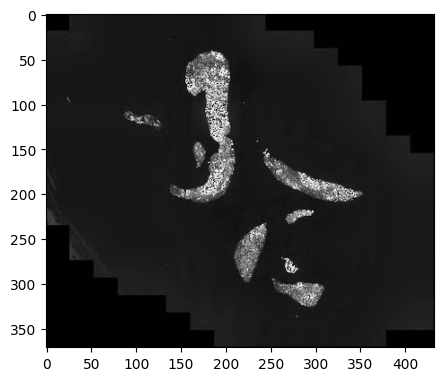

In [18]:
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray')
# plt.title(f"Pair {idx+1}, Region {i+1}")
plt.show()

In [19]:
# Find connected components
_, binarized_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
masks = find_connected_components(binarized_img)
print(len(masks))

# Find pairs based on shape similarity
pairs = find_pairs(masks, min_area=50)

8
(8, 9)
[[1.00000000e+00 1.00000000e+00 1.00000000e+00 9.46538717e-01
  8.33055582e-01 1.00000000e+00 1.06508717e-18 1.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.72381475e-02 4.03239686e-01 2.54195740e-01
  1.35168340e-01 2.42009198e-02 0.00000000e+00 0.00000000e+00
  3.00551752e-19]
 [1.33508165e-02 1.72381473e-02 4.66014154e-03 1.54869470e-02
  0.00000000e+00 0.00000000e+00 1.14397417e-21 2.02049708e-02
  2.98956863e-19]
 [3.01585409e-01 5.74961511e-01 9.51383779e-01 1.00000000e+00
  1.00000000e+00 7.53317908e-01 7.52282661e-19 7.15501469e-01
  4.84039803e-20]
 [2.95625224e-02 2.14208233e-02 2.35243753e-01 1.86510080e-01
  1.41857952e-01 6.93876818e-02 8.33630740e-21 4.57491711e-02
  2.93613685e-19]
 [2.08725712e-01 2.78182870e-01 1.79321755e-01 1.23477351e-01
  8.12547560e-02 8.94107339e-03 7.12702459e-22 1.31000649e-02
  2.98876701e-19]
 [8.70187150e-03 0.00000000e+00 5.58488536e-02 1.46826995e-02
  1.20060898e-01 2.72335530e-02 2.99989090e-21 2.63586302e-02
  2.97791328e-1

In [20]:
pairs

[(0, 3), (5, 7), (4, 1), (2, 6)]

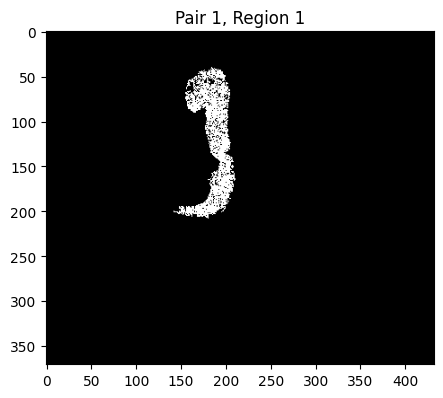

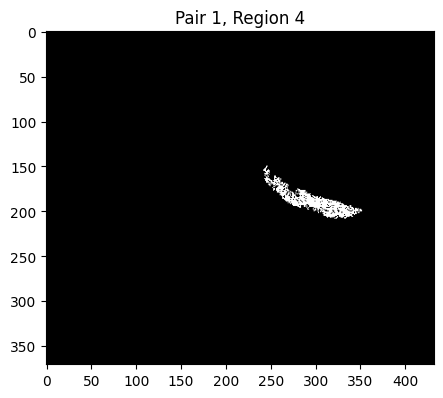

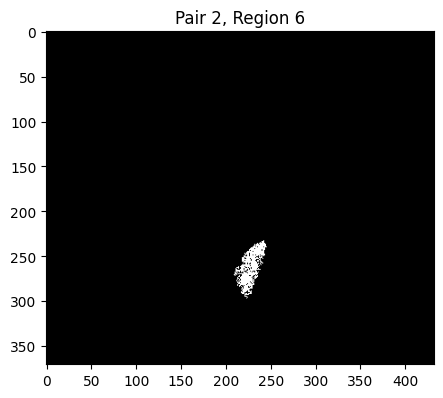

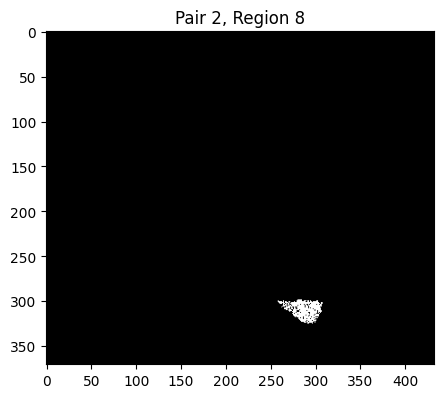

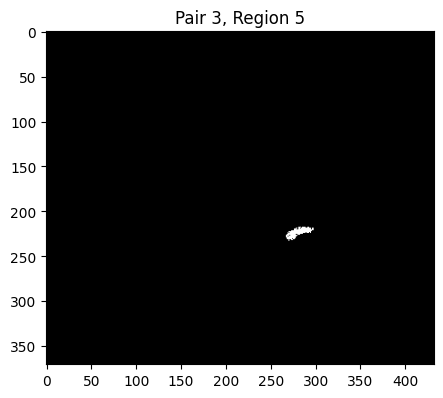

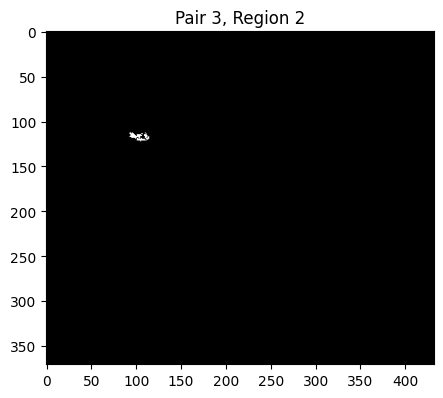

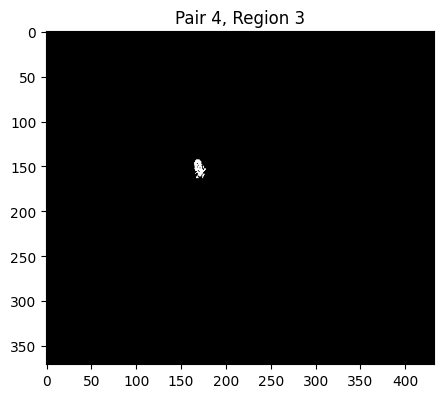

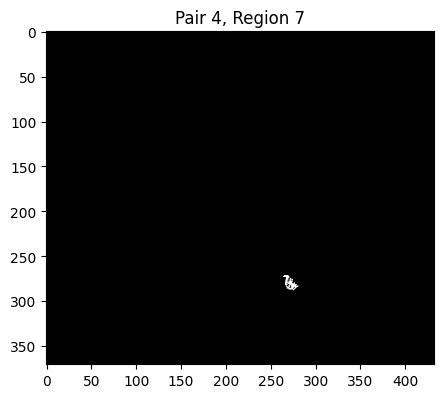

In [21]:
# Display each mask and its associated cluster label
for idx, pair in enumerate(pairs):
    for i in pair:
        plt.figure(figsize=(5, 5))
        plt.imshow(masks[i], cmap='gray')
        plt.title(f"Pair {idx+1}, Region {i+1}")
        plt.show()
        # cv2.imshow(f"Pair {idx+1}, Region {i+1}", masks[i])
        # cv2.waitKey(0)

In [22]:
import math

# def cosine_similarity(A, B):
#     dot_product = np.dot(A, B)
#     norm_a = np.linalg.norm(A)
#     norm_b = np.linalg.norm(B)
#     return dot_product / (norm_a * norm_b)

def calculate_center(mask):
    # print(mask.shape)
    y, x = np.where(mask)
    return np.mean(x), np.mean(y)

def calculate_direction(point_a, point_b):
    vector = (point_b[0]-point_a[0], point_b[1]-point_a[1])
    angle = math.degrees(math.atan2(vector[1], vector[0]))
    return vector, angle

center_1 = calculate_center(masks[pairs[0][0]])
center_2 = calculate_center(masks[pairs[0][1]])
base_vector, base_angle = calculate_direction(center_1, center_2)
# base_vector = (point_b[0]-point_a[0], point_b[1]-point_a[1])
corrected_pairs = [pairs[0]]

for pair in pairs[1:]:
    center_1 = calculate_center(masks[pair[0]])
    center_2 = calculate_center(masks[pair[1]])
    
    vector, angle = calculate_direction(center_1, center_2)
    # print(distance.euclidean(vector, base_vector))
    # if distance.euclidean(vector, base_vector) > 200:
    #     continue
    if abs(angle - base_angle) < 60:
        if distance.euclidean(vector, base_vector) < 200:
            corrected_pairs.append(pair)
    elif abs(angle - base_angle) > 120:
        if distance.euclidean(calculate_direction(center_2, center_1)[0], base_vector) < 200:
            corrected_pairs.append(pair[::-1])
    else:
        continue
    # print(angle)

print(corrected_pairs)

[(0, 3), (5, 7), (1, 4), (2, 6)]


In [23]:
# mask_group_1, mask_group_2 = [], []
# for pair in pairs:
#     mask_group_1.append(pair[0])
#     mask_group_2.append(pair[1])
mask_group_1 = [pair[0] for pair in corrected_pairs]
mask_group_2 = [pair[1] for pair in corrected_pairs]
mask_group_1, mask_group_2

([0, 5, 1, 2], [3, 7, 4, 6])

In [24]:
masks[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [25]:
mask_1 = sum([masks[i] for i in mask_group_1])
mask_2 = sum([masks[i] for i in mask_group_2])

In [26]:
mask_1.shape

(371, 432)

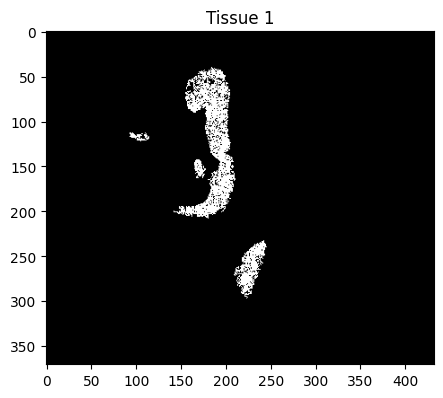

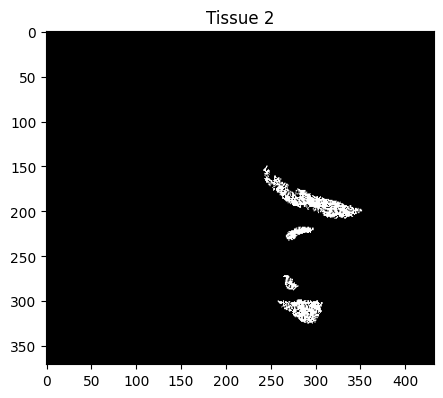

In [27]:
plt.figure(figsize=(5, 5))
plt.imshow(mask_1, cmap='gray')
plt.title('Tissue 1')
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(mask_2, cmap='gray')
plt.title('Tissue 2')
plt.show()

In [28]:
def bounding_box(mask, margin=20):
    # 找到mask中的轮廓
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 找到边界框
    x, y, w, h = cv2.boundingRect(contours[0])
    for cnt in contours[1:]:
        x1, y1, w1, h1 = cv2.boundingRect(cnt)
        x, y, w, h = min(x, x1), min(y, y1), max(x+w, x1+w1) - min(x, x1), max(y+h, y1+h1) - min(y, y1)
    
    # 添加边缘
    x = max(0, x - margin)
    y = max(0, y - margin)
    w = min(mask.shape[1] - x, w + 2 * margin)
    h = min(mask.shape[0] - y, h + 2 * margin)
    
    # 限制在[0, 1]范围内
    img_height, img_width = mask.shape
    x, w = x / img_width, w / img_width
    y, h = y / img_height, h / img_height
    
    return x, y, w, h

(0.16898148148148148, 0.05390835579514825, 0.44675925925925924, 0.8032345013477089)


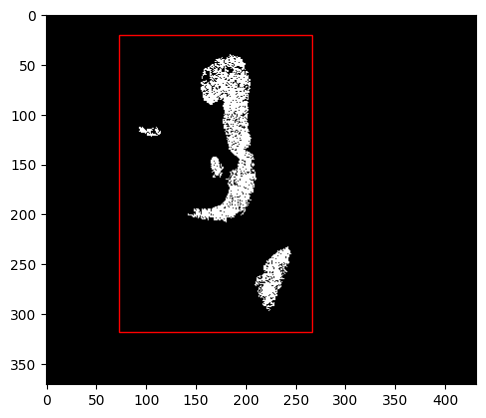

In [29]:
import matplotlib.patches as patches

x, y, w, h = bounding_box(mask_1)
print((x, y, w, h))
img_height, img_width = mask_1.shape

# 使用Matplotlib进行可视化
fig, ax = plt.subplots(1)
ax.imshow(mask_1, cmap='gray')  # 显示原始的mask

# 画边界框
rect = patches.Rectangle((x * img_width, y * img_height), w*img_width, h*img_height, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.show()

(0.5138888888888888, 0.3504043126684636, 0.3472222222222222, 0.5822102425876011)


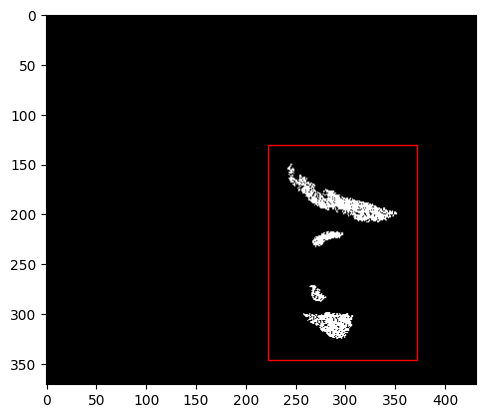

In [30]:
x, y, w, h = bounding_box(mask_2)
print((x, y, w, h))
img_height, img_width = mask_2.shape

# 使用Matplotlib进行可视化
fig, ax = plt.subplots(1)
ax.imshow(mask_2, cmap='gray')  # 显示原始的mask

# 画边界框
rect = patches.Rectangle((x * img_width, y * img_height), w*img_width, h*img_height, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.show()